In [1]:
%matplotlib
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from scipy.constants import pi,h
import functools
import operator

Using matplotlib backend: Qt5Agg


In [198]:
# old
def hamiltonian_t_pulseTrain(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args[0]
    H1 = args[1]
    time_part = functools.reduce(operator.add, [np.exp(-(t-args[3]-i*2*pi/args[4])**2/2/args[2]**2) * (np.heaviside(t-i*2*pi/w_01,1)+np.heaviside(t+2*tc-i*2*pi/w_01,-1)) for i in range(n)])
    
    return H0 +  H1 * time_part

In [258]:
# check a Gaussian pulse train
t1 = np.linspace(0, n * 2*pi/w_01, 100001)
y1 = functools.reduce(operator.add, [ np.exp(-(t1-tc -i*2*pi/w_01)**2/2/tau**2) * (np.heaviside(t1-i*2*pi/w_01,0)- np.heaviside(t1-2*tc-i*2*pi/w_01,0)) for i in range(n)])

In [259]:
# plt.plot(t0,y0) np.exp(-(t1-tc -i*2*pi/w_01)**2/2/tau**2) *
plt.plot(t1, y1)

# Using a SFQ pulse train in H1(t)

In [5]:
# parameters
w_01 = 5 * 2 *pi # in GHz*2*pi 
tau = 2e-3 # in ns 
tc = 5*tau # in ns 
del_theta = 2*pi/360*2 # in rad
hbar = 1
n = 90

In [6]:
def H1_coeff(t, args):
    out = functools.reduce(operator.add, [np.exp(-(t-args['tc']-i*2*pi/args['w_01'])**2/2/args['tau']**2) * (np.heaviside(t-i*2*pi/args['w_01'],0)+np.heaviside(t+2*args['tc']-i*2*pi/args['w_01'],0)) for i in range(args['n'])])
    return out

psi0 = basis(2,0)
H0 = hbar*w_01/2*(qeye(2) - sigmaz()) 
H1 = hbar*del_theta/2/np.sqrt(2*pi)/tau*sigmay()
tlist_pulseTrain = np.linspace(0, n * 2*pi/w_01, 501)
H = [H0, [H1, H1_coeff]]
args = {'tau':tau, 'tc': tc, 'w_01': w_01,'n':n}
output = mesolve(H, psi0, tlist_pulseTrain, [], [sigmaz()], args, progress_bar=True)  

10.2%. Run time:   1.78s. Est. time left: 00:00:00:15
20.2%. Run time:   3.34s. Est. time left: 00:00:00:13
30.1%. Run time:   4.88s. Est. time left: 00:00:00:11
40.1%. Run time:   6.47s. Est. time left: 00:00:00:09
50.1%. Run time:   8.17s. Est. time left: 00:00:00:08
60.1%. Run time:   9.80s. Est. time left: 00:00:00:06
70.1%. Run time:  11.35s. Est. time left: 00:00:00:04
80.0%. Run time:  12.87s. Est. time left: 00:00:00:03
90.0%. Run time:  14.47s. Est. time left: 00:00:00:01
Total run time:  16.04s


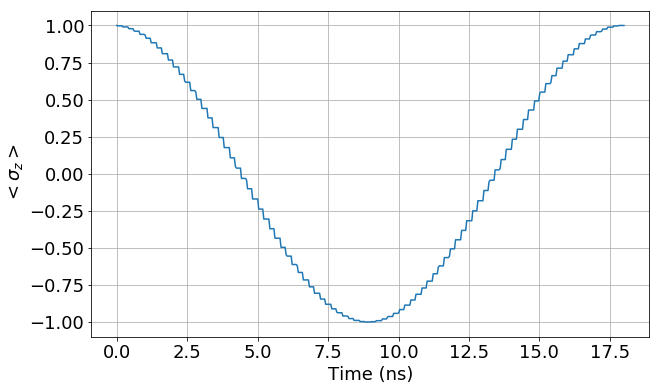

In [7]:
fig,ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(tlist_pulseTrain, output.expect[0])
ax.set_xlabel('Time (ns)', fontsize=18)
ax.set_ylabel(r'$<\sigma_z>$', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid('on')

# Using evolution operator

In [9]:
def H1_coeff_1(t, args):
#     return np.exp(-(t-args['tc'])**2/2/args['tau']**2)
    return np.exp(-t**2/2/args['tau']**2)

U_f = lambda t: (1j*w_01*t/2*sigmaz()).expm()

In [10]:
# parameters
w_01 = 5 * 2 *pi # in GHz*2*pi 
tau = 2e-3 # in ns 
tc = 5*tau # in ns 
del_theta = 2*pi/360*2 # in rad
hbar = 1
n = 360

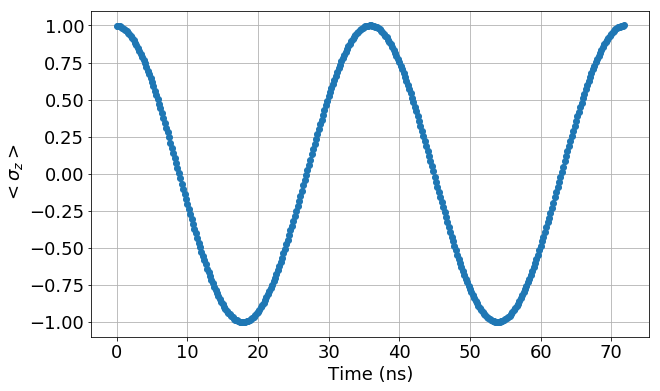

In [11]:
# Compute evolution operator per one unit of SFQ pulse train,i.e., one SFQ + free evolotuion
H0 = hbar*w_01/2*(qeye(2) - sigmaz()) 
H1 = hbar*del_theta/2/np.sqrt(2*pi)/tau*sigmay() 
H = [H0, [H1, H1_coeff_1]]

tlist = np.linspace(-tc, tc, 101)
args = {'tau':tau, 'tc':tc, 'w_01':w_01}

U_single_Gauss = propagator(H, tlist, [], args=args)
U_single = U_f(2*pi/w_01-tc) * U_single_Gauss[-1] * U_f(-tc)

U1 = [U_single]
for i in range(n-1):
    U1.append(U_single*U1[-1])
    
sigmaz_expect = expect(sigmaz(), U1*basis(2,0)) # expectation value of sigma_z

# plot
fig,ax = plt.subplots(1,1, figsize=(10,6))
tlist = [2*pi/w_01*i for i in range(n)]
ax.plot(tlist, sigmaz_expect,'-o')
ax.set_xlabel('Time (ns)', fontsize=18)
ax.set_ylabel(r'$<\sigma_z>$', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid('on')

# Fid vs n

In [25]:
theta = pi/2

for n in range(n_max):
    U_id = (1j*theta*sigmay()/2).expm()
    Fid = (np.absolute((U_id.dag() * U_G(U_single,n))[-1].tr())**2+2 )/6

